# Introduction

In the following notebook, I will be modeling Airbnb Listings data to create a price predictor to using a Deep Learning model

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow import keras

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set notebook preferences**

In [2]:
#Set options for pandas
pd.set_option('display.max_columns',1_000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Set options for numpy
np.set_printoptions(suppress=True)

#Set visualization preferences
plt.style.use('Solarize_Light2')

#Surpress warnings
import warnings
warnings.simplefilter('ignore')

#Set path to training data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Data\03_Processed'

#Set path to write visuals
viz_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Visualizations\Modeling'

**Read in data**

In [3]:
#Read data
df = pd.read_csv(path + '/2020_0608_Listings_Processed.csv', index_col=0)

**Preview Data**

In [4]:
#Preview data
print('Data shape:',df.shape)
display(df.head())

Data shape: (82433, 42)


,accommodates,amenities_count,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,cancellation_policy,cleaning_fee,extra_people,guests_included,holiday,host_has_profile_pic,host_identity_verified,host_is_superhost,host_response_rate,host_response_time,instant_bookable,is_location_exact,last_review_month_encoded,last_review_weekday_encoded,last_review_year_encoded,maximum_nights,minimum_nights,neighbourhood_cleansed_encoded,number_of_reviews,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_rating,reviews_per_month,room_type,security_deposit,weekend
0,3,36,25,106,43,58,1.000,Real Bed,1.000,2.000,1,0,0,moderate,100.000,25.000,2,False,1.000,1.000,1.000,90.000,within an hour,1,1,203.282,241.670,217.141,1125,1,248.227,240,170.000,Apartment,0,0,1,97.000,1.840,Entire home/apt,100.000,False
1,5,17,0,0,0,0,1.000,Real Bed,2.000,3.000,1,0,0,strict 14 with grace period,100.000,0.000,2,False,1.000,1.000,0.000,100.000,within a day,0,1,223.910,217.530,215.357,60,30,185.379,111,235.000,Apartment,0,0,1,98.000,0.830,Entire home/apt,2.000,True
2,2,18,30,365,60,90,4.000,Real Bed,1.000,1.000,9,9,0,strict 14 with grace period,50.000,12.000,1,False,1.000,1.000,0.000,100.000,within an hour,0,1,203.282,241.670,217.141,60,32,211.965,19,65.000,Apartment,0,0,1,84.000,0.150,Private room,200.000,False
3,2,16,30,365,60,90,4.000,Real Bed,1.000,1.000,9,9,0,strict 14 with grace period,50.000,12.000,1,False,1.000,1.000,0.000,100.000,within an hour,0,1,202.584,209.425,223.098,90,32,211.965,8,65.000,Apartment,0,0,1,93.000,0.120,Private room,200.000,False
5,3,33,30,173,56,84,1.000,Real Bed,1.000,1.000,2,2,0,strict 14 with grace period,50.000,60.000,2,False,1.000,0.000,1.000,100.000,within an hour,1,1,203.282,208.033,217.141,14,1,220.275,736,139.000,Condominium,0,0,1,98.000,5.660,Private room,0.000,False


# Model Development

### Prepare Data

**Split data into X and y**

In [5]:
#Split data into X and y
X = df.drop('price', axis = 1)
y = df.price.values

**One-Hot Encode**

In [6]:
#Read in Libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Subset categorical variables
cat_features = X.select_dtypes('object').columns

#Init ColumnTransformer 
ct = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features)],remainder='passthrough')

#One-hot encode categorical variables'
X_encoded = ct.fit_transform(X)

**Split data and scale**

In [7]:
#Import libraries
from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, 
                                                    test_size = .2,
                                                   random_state = 24)

#Check
print('Training data:{} | Training labels:{}'.format(X_train.shape,y_train.shape))
print('Test data:{} | Test labels:{}'.format(X_test.shape,y_test.shape))

Training data:(65946, 85) | Training labels:(65946,)
Test data:(16487, 85) | Test labels:(16487,)


In [8]:
#Init scaler
scaler = StandardScaler()

#Fit and transform training and test data
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [9]:
X_train_transformed.shape

(65946, 85)

## Base model

**Build and compile**

In [10]:
tf.keras.backend.clear_session()

#Init base model
base_model = tf.keras.models.Sequential()

#Add Layers
base_model.add(tf.keras.layers.Dense(units = 85, activation = 'relu', input_shape = (85,)))
base_model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
base_model.add(tf.keras.layers.Dense(units = 1))

#compile
base_model.compile(loss = 'mean_squared_error', optimizer = 'Adam',)

**Train Base Model**

In [11]:
#Train model
history = base_model.fit(X_train_transformed,y_train, validation_split=.2, batch_size= 100,epochs=200,shuffle=True)

Epoch 1/200
528/528 [==============================] - 1s 2ms/step - loss: 9454.0693 - val_loss: 3756.3569
Epoch 2/200
528/528 [==============================] - 1s 1ms/step - loss: 3462.2397 - val_loss: 3507.3276
Epoch 3/200
528/528 [==============================] - 1s 1ms/step - loss: 3300.2227 - val_loss: 3372.8550
Epoch 4/200
528/528 [==============================] - 1s 1ms/step - loss: 3205.4199 - val_loss: 3310.5437
Epoch 5/200
528/528 [==============================] - 1s 1ms/step - loss: 3124.4958 - val_loss: 3219.6421
Epoch 6/200
528/528 [==============================] - 1s 1ms/step - loss: 3050.4961 - val_loss: 3151.8896
Epoch 7/200
528/528 [==============================] - 1s 1ms/step - loss: 2965.1277 - val_loss: 3061.4856
Epoch 8/200
528/528 [==============================] - 1s 1ms/step - loss: 2881.6665 - val_loss: 2983.2808
Epoch 9/200
528/528 [==============================] - 1s 1ms/step - loss: 2803.0833 - val_loss: 2909.9854
Epoch 10/200
528/528 [===============

**Evaluate Training Loss**

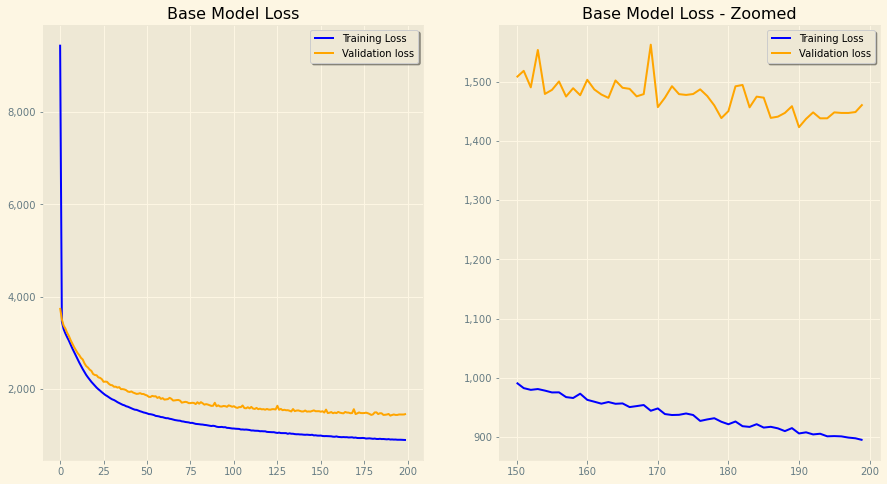

In [12]:
#Store training loss as a data frame
training_loss = pd.DataFrame()
training_loss['loss'] = history.history['loss']
training_loss['val_loss'] = history.history['val_loss']

#Create figure
f, ax = plt.subplots(1,2,figsize = (15,8))

#Plot training loss
training_loss.plot(ax=ax[0], color = ['blue', 'orange'])
training_loss[150:].plot(ax=ax[1], color = ['blue', 'orange'])

#Set plot aesthetics
ax[0].set_title('Base Model Loss')
ax[0].legend(['Training Loss', 'Validation loss'], frameon = True, shadow = True)
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax[1].set_title('Base Model Loss - Zoomed')
ax[1].legend(['Training Loss', 'Validation loss'], frameon = True, shadow = True)
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/Base_Model_Loss.png',bbox_inches='tight')

**Save/Load Trained Base Model**

In [13]:
#Set path to save/load trained model
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models'

#Save Trained model
tf.keras.models.save_model(model = base_model, filepath = path + '/Base_ANN_Regressor')

# #Load saved model
# base_model = tf.keras.models.load_model(filepath = path + '/Base_ANN_Regressor')

#Print model summary
print('Base ANN Summary:\n', base_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models/Base_ANN_Regressor\assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 85)                7310      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5504      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 12,879
Trainable params: 12,879
Non-trainable params: 0
_________________________________________________________________
Base ANN Summary:
 None


**Evaluate base model on test data**

In [14]:
#Read in regression metrics
from Regression_Metrics import regression_metrics

#Evaluate performance on test data
predictions = base_model.predict(X_test_transformed,batch_size=100)

#Store predictions, actual, and error
base_results = pd.DataFrame(predictions, columns=['predictions'])
base_results['actual']=y_test
base_results['error'] = base_results['predictions'] - base_results['actual']

Base Model Evaluation Metrics:
R2: 0.8359871807874719
MAE: 25.77983382479456 
MSE: 16216.751755146885
RMSE: 127.34501071948945


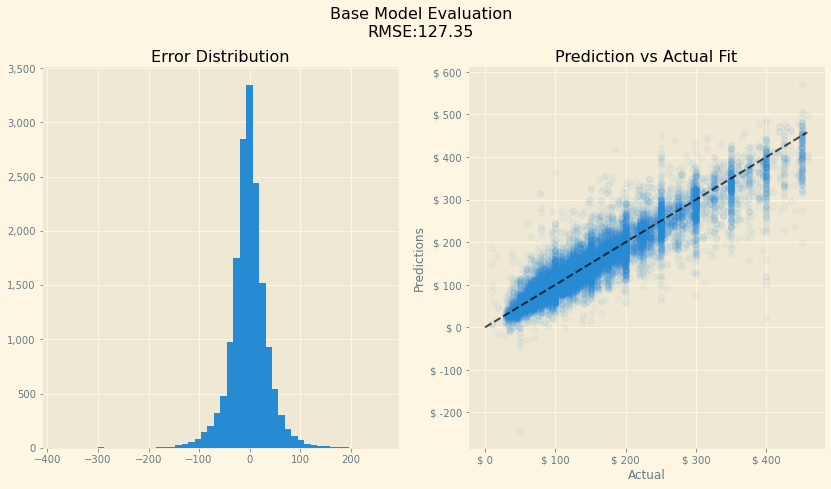

In [15]:
#View results
metrics = regression_metrics('Base Model', predictions, y_test)

#Create figure
f, ax = plt.subplots(1,2,figsize = (14,7))

#Plot error distribution
base_results.error.hist(ax = ax[0], bins = 50)

#PLot Predictions against Actual
ax[1].scatter(x = base_results.actual, y = base_results.predictions, alpha = .04)

#PLot best fit line
X=list(np.arange(0,max(base_results.actual)))
ax[1].plot(X,X, color = 'black', linestyle = '--', alpha = .7)

#Set plot aesthetics
plt.suptitle('Base Model Evaluation\nRMSE:{}'.format(round(metrics['rmse'],2)), y =1.0, fontsize = 16)
ax[0].set_title('Error Distribution')
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax[1].set_title('Prediction vs Actual Fit')
ax[1].set_xlabel('Actual')
ax[1].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))
ax[1].set_ylabel('Predictions')
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/Base_Model_Error_Evaluation.png',bbox_inches='tight')

## ANN Model V1

**Build Model**

Initial model was underfitting. We'll add layers to our next iteration of the model and also increase the number of epochs to 300

In [16]:
#Rest Session
tf.keras.backend.clear_session()

#Init base model
model_v1 = tf.keras.models.Sequential()

#Add Layers
model_v1.add(tf.keras.layers.Dense(units = X_train_transformed.shape[1], activation = 'relu',input_shape=(X_train_transformed.shape[1],)))
model_v1.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model_v1.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model_v1.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v1.add(tf.keras.layers.Dense(units = 32, activation = 'relu'))
model_v1.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

#compile
model_v1.compile(loss = 'mean_squared_error', optimizer = 'Adam',)

**Train model_v1**

In [18]:
history = model_v1.fit(X_train_transformed, y_train,epochs=300, validation_split=.2, shuffle=True, batch_size = 100 )

Epoch 1/300
528/528 [==============================] - 1s 2ms/step - loss: 5679.4116 - val_loss: 3406.9817
Epoch 2/300
528/528 [==============================] - 1s 2ms/step - loss: 3055.2410 - val_loss: 2964.1682
Epoch 3/300
528/528 [==============================] - 1s 2ms/step - loss: 2757.1780 - val_loss: 2798.8333
Epoch 4/300
528/528 [==============================] - 1s 2ms/step - loss: 2548.9619 - val_loss: 2607.4285
Epoch 5/300
528/528 [==============================] - 1s 2ms/step - loss: 2363.5256 - val_loss: 2534.1428
Epoch 6/300
528/528 [==============================] - 1s 2ms/step - loss: 2211.1292 - val_loss: 2345.5408
Epoch 7/300
528/528 [==============================] - 1s 2ms/step - loss: 2074.2715 - val_loss: 2296.2083
Epoch 8/300
528/528 [==============================] - 1s 2ms/step - loss: 1939.1307 - val_loss: 2167.2981
Epoch 9/300
528/528 [==============================] - 1s 2ms/step - loss: 1830.3038 - val_loss: 2100.0305
Epoch 10/300
528/528 [===============

**Evaluate Training Loss**

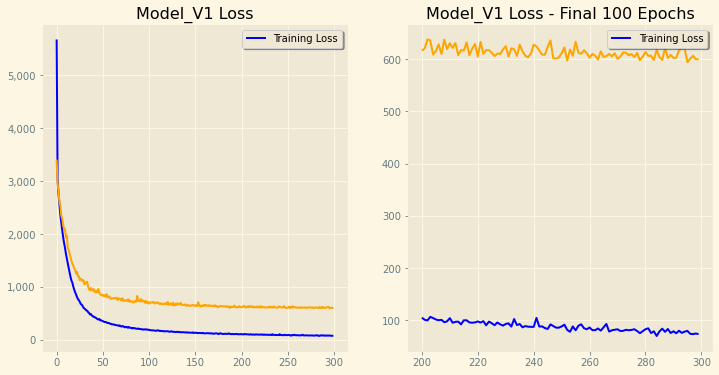

In [19]:
#Store training loss 
training_loss = pd.DataFrame()
training_loss['loss'] = history.history['loss']
training_loss['val_loss'] = history.history['val_loss']

#Create figure
f, ax = plt.subplots(1,2,figsize = (12,6))

#Plot training loss
training_loss.plot(ax=ax[0], color = ['blue','orange'])
training_loss[200:300].plot(ax=ax[1], color = ['blue','orange'])

#Set plot aesthetics
ax[0].set_title('Model_V1 Loss')
ax[0].legend(['Training Loss'], frameon = True, shadow = True)
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Set plot aesthetics
ax[1].set_title('Model_V1 Loss - Final 100 Epochs')
ax[1].legend(['Training Loss'], frameon = True, shadow = True)
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Save figure
#plt.savefig(viz_path + '/Model_V1.png',bbox_inches='tight')

**Save/Load Trained Base Model**

In [20]:
#Set path to save/load trained model
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models'

#Save Trained model
tf.keras.models.save_model(model = model_v1, filepath = path + '/Base_ANN_Regressor')

# #Load saved model
# model_v1 = tf.keras.models.load_model(filepath = path + '/ANN_Regressor_V1')

#Print model summary
print('V1 ANN Summary:\n', model_v1.summary())

INFO:tensorflow:Assets written to: C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models/Base_ANN_Regressor\assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 85)                7310      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               11008     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
______________________________________

**Evaluate base model on test data**

In [21]:
#Get predictions
v1_predictions = model_v1.predict(X_test_transformed, batch_size = 100)

In [22]:
#Store predictions, actual, and error
v1_results = pd.DataFrame(v1_predictions, columns=['predictions'])
v1_results['actual']=y_test
v1_results['error'] = v1_results['predictions'] - v1_results['actual']

#Evaluate Results
v1_metrics = regression_metrics('ANN Model V1', v1_predictions, y_test)

ANN Model V1 Evaluation Metrics:
R2: 0.939560794640678
MAE: 12.664999042769434 
MSE: 16128.452275467956
RMSE: 126.99784358589699


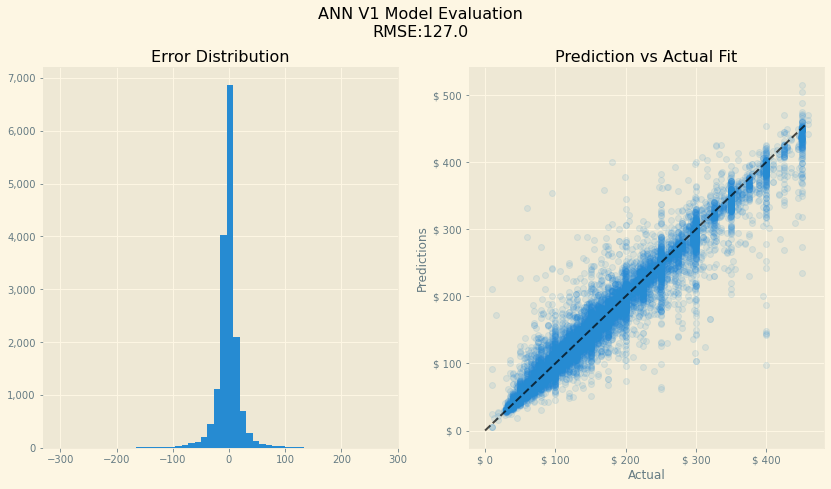

In [23]:
#Create figure
f, ax = plt.subplots(1,2,figsize = (14,7))

#Plot error distribution
v1_results.error.hist(ax = ax[0], bins = 50)

#PLot Predictions against Actual
ax[1].scatter(x = v1_results.actual, y = v1_results.predictions, alpha = .1)

#PLot best fit line
X=list(np.arange(0,max(v1_results.actual)))
ax[1].plot(X,X, color = 'black', linestyle = '--', alpha = .7)

#Set plot aesthetics
plt.suptitle('ANN V1 Model Evaluation\nRMSE:{}'.format(round(v1_metrics['rmse'],2)), y =1.0, fontsize = 16)
ax[0].set_title('Error Distribution')
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax[1].set_title('Prediction vs Actual Fit')
ax[1].set_xlabel('Actual')
ax[1].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))
ax[1].set_ylabel('Predictions')
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/ANNV1_Error_Evaluation.png',bbox_inches='tight')

## ANN Model V2

**Build Model**

Model is now overfitting, we'll add some dropout

In [26]:
#Rest Session
tf.keras.backend.clear_session()

#Init base model
model_v2 = tf.keras.models.Sequential()

#Add La2ers
model_v2.add(tf.keras.layers.Dense(units = X_train_transformed.shape[1], activation = 'relu',input_shape=(X_train_transformed.shape[1],)))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

#compile
model_v2.compile(loss = 'mean_squared_error', optimizer = 'Adam',)

**Train Model**

In [ ]:
history = model_v2.fit(X_train_transformed, y_train, shuffle=True, validation_split=.2, epochs = 300, batch_size = 300)

Epoch 1/300
176/176 [==============================] - 1s 5ms/step - loss: 10164.0596 - val_loss: 4028.3311
Epoch 2/300
176/176 [==============================] - 1s 4ms/step - loss: 4700.8120 - val_loss: 3595.0549
Epoch 3/300
176/176 [==============================] - 1s 4ms/step - loss: 4312.1504 - val_loss: 3692.7537
Epoch 4/300
176/176 [==============================] - 1s 4ms/step - loss: 4102.2910 - val_loss: 3366.1423
Epoch 5/300
176/176 [==============================] - 1s 4ms/step - loss: 3960.9788 - val_loss: 3259.9194
Epoch 6/300
176/176 [==============================] - 1s 4ms/step - loss: 3879.3794 - val_loss: 3268.4568
Epoch 7/300
176/176 [==============================] - 1s 4ms/step - loss: 3748.2720 - val_loss: 3109.4224
Epoch 8/300
176/176 [==============================] - 1s 4ms/step - loss: 3723.9221 - val_loss: 3179.8711
Epoch 9/300
176/176 [==============================] - 1s 4ms/step - loss: 3637.0769 - val_loss: 3246.2283
Epoch 10/300
176/176 [==============

**Evaluate Training Loss**

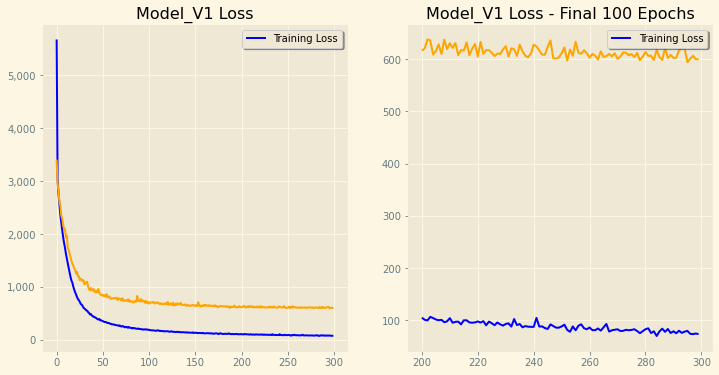

In [19]:
#Store training loss 
training_loss = pd.DataFrame()
training_loss['loss'] = history.history['loss']
training_loss['val_loss'] = history.history['val_loss']

#Create figure
f, ax = plt.subplots(1,2,figsize = (12,6))

#Plot training loss
training_loss.plot(ax=ax[0], color = ['blue','orange'])
training_loss[200:300].plot(ax=ax[1], color = ['blue','orange'])

#Set plot aesthetics
ax[0].set_title('Model_V1 Loss')
ax[0].legend(['Training Loss'], frameon = True, shadow = True)
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Set plot aesthetics
ax[1].set_title('Model_V1 Loss - Final 100 Epochs')
ax[1].legend(['Training Loss'], frameon = True, shadow = True)
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Save figure
#plt.savefig(viz_path + '/Model_V1.png',bbox_inches='tight')

**Save/Load Trained Base Model**

In [20]:
#Set path to save/load trained model
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models'

#Save Trained model
tf.keras.models.save_model(model = model_v1, filepath = path + '/Base_ANN_Regressor')

# #Load saved model
# model_v1 = tf.keras.models.load_model(filepath = path + '/ANN_Regressor_V1')

#Print model summary
print('V1 ANN Summary:\n', model_v1.summary())

INFO:tensorflow:Assets written to: C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models/Base_ANN_Regressor\assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 85)                7310      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               11008     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
______________________________________

**Evaluate base model on test data**

In [21]:
#Get predictions
v1_predictions = model_v1.predict(X_test_transformed, batch_size = 100)

In [22]:
#Store predictions, actual, and error
v1_results = pd.DataFrame(v1_predictions, columns=['predictions'])
v1_results['actual']=y_test
v1_results['error'] = v1_results['predictions'] - v1_results['actual']

#Evaluate Results
v1_metrics = regression_metrics('ANN Model V1', v1_predictions, y_test)

ANN Model V1 Evaluation Metrics:
R2: 0.939560794640678
MAE: 12.664999042769434 
MSE: 16128.452275467956
RMSE: 126.99784358589699


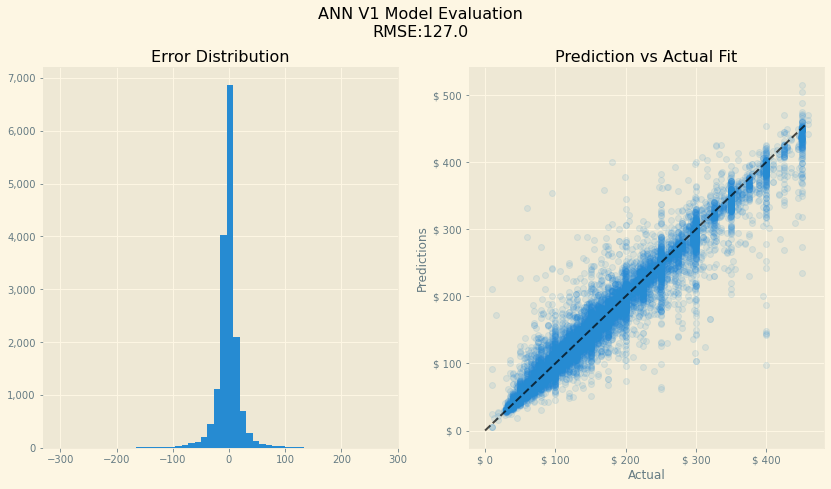

In [23]:
#Create figure
f, ax = plt.subplots(1,2,figsize = (14,7))

#Plot error distribution
v1_results.error.hist(ax = ax[0], bins = 50)

#PLot Predictions against Actual
ax[1].scatter(x = v1_results.actual, y = v1_results.predictions, alpha = .1)

#PLot best fit line
X=list(np.arange(0,max(v1_results.actual)))
ax[1].plot(X,X, color = 'black', linestyle = '--', alpha = .7)

#Set plot aesthetics
plt.suptitle('ANN V1 Model Evaluation\nRMSE:{}'.format(round(v1_metrics['rmse'],2)), y =1.0, fontsize = 16)
ax[0].set_title('Error Distribution')
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax[1].set_title('Prediction vs Actual Fit')
ax[1].set_xlabel('Actual')
ax[1].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))
ax[1].set_ylabel('Predictions')
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/ANNV1_Error_Evaluation.png',bbox_inches='tight')